t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 2min 23s, sys: 16.8 s, total: 2min 40s
Wall time: 1min 58s


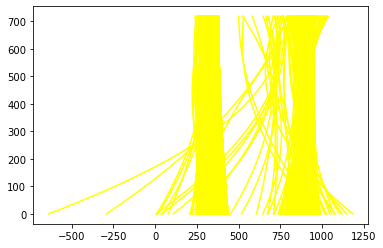

In [1]:
from moviepy.editor import VideoFileClip
import glob
import matplotlib.pyplot as plt
import camera_calibration
import undistort
import thresholded_binary
import perspective_transform
import find_lane
import curvature_and_offset
import original_lane

images = glob.glob('camera_cal/calibration*.jpg')
mtx, dist = camera_calibration.camera_calib(images)

def video_pipeline(pipeline_image):
    # Undistort the image
    undistorted_image = undistort.undistort_image(pipeline_image, mtx, dist)

    # Apply the combined thresholds on the image to get a combined binary image
    color_binary, combined_binary = thresholded_binary.create_thresholded_binary_image(undistorted_image)

    # Create interest mask
    after_mask = perspective_transform.create_interest_mask(combined_binary)
    
    # Create transform perspective
    transformed_perspective_image, M, Minv = perspective_transform.transform_perspective(after_mask)

    # Find the lane line from the polynomials formed
    sliding_window_img, ploty, left_fit, right_fit, left_fitx, right_fitx = find_lane.fit_polynomial(transformed_perspective_image)

    # In the next frame, find lane lines from the lane lines of the last frame
    result = find_lane.search_around_poly(transformed_perspective_image, left_fit, right_fit)
    
    # Calculates the curvature of polynomial functions in meters
    curvature = curvature_and_offset.measure_curvature_pixels(ploty, left_fit, right_fit)
    
    # Calculate position of the car from the centre
    offset = curvature_and_offset.offset((left_fit, right_fit), pipeline_image)
    
    #plt.imshow(transformed_perspective_image)
    #plt.show()
    original_lane_image = original_lane.original_lane_lines(transformed_perspective_image, undistorted_image, (left_fitx, right_fitx), Minv)

    # return orig_lane_image
    return original_lane_image

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
final_clip = clip1.fl_image(video_pipeline)#NOTE: this function expects color images!!
%time final_clip.write_videofile(output, audio=False)